<a href="https://colab.research.google.com/github/LokiAndere/MIARFID-VPC-2019-20/blob/master/bilinearapproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b

import os

batch_size = 32
num_classes = 20
epochs = 150

Using TensorFlow backend.


In [4]:
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')

0

(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


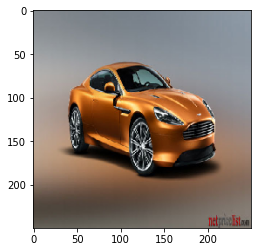

In [2]:
# Load
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[69,:,:,: ] )
plt.show()

In [0]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
backend.clear_session()

modelA=VGG16(weights='imagenet', include_top=False)

for i, layer in enumerate(modelA.layers):
    if i<9:
      a = '_A0'
    else:
      a = '_A'
    layer.name = layer.name + a + str(i)
    layer.trainable = True

modelA.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_A00 (InputLayer)     (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1_A01 (Conv2D)    (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2_A02 (Conv2D)    (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool_A03 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1_A04 (Conv2D)    (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2_A05 (Conv2D)    (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool_A06 (MaxPooling2 (None, None, None, 128)   0     

In [5]:
backend.clear_session()

modelB=VGG16(weights='imagenet', include_top=False)

for i, layer in enumerate(modelB.layers):
    if i<9:
      a = '_B0'
    else:
      a = '_B'
    layer.name = layer.name + a + str(i)
    layer.trainable = True

modelB.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_B00 (InputLayer)     (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1_B01 (Conv2D)    (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2_B02 (Conv2D)    (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool_B03 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1_B04 (Conv2D)    (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2_B05 (Conv2D)    (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool_B06 (MaxPooling2 (None, None, None, 128)   0     

In [0]:

#############################
###      BILINEAR        ####
#############################

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,3*3)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt)								              # Apply l2 normalization
  z_bn = BN()(y_ssqrt)
  return z_bn

d1=modelA.layers[-1].output
d2=modelB.layers[-1].output

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

inputM = [modelA.input,modelB.input]
model = Model(inputs=inputM, outputs=predictions)

In [0]:
datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

In [0]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
  
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_A00 (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_1_B00 (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1_A01 (Conv2D)       (None, None, None, 6 1792        input_1_A00[0][0]                
__________________________________________________________________________________________________
block1_conv1_B01 (Conv2D)       (None, None, None, 6 1792        input_1_B00[0][0]                
____________________________________________________________________________________________

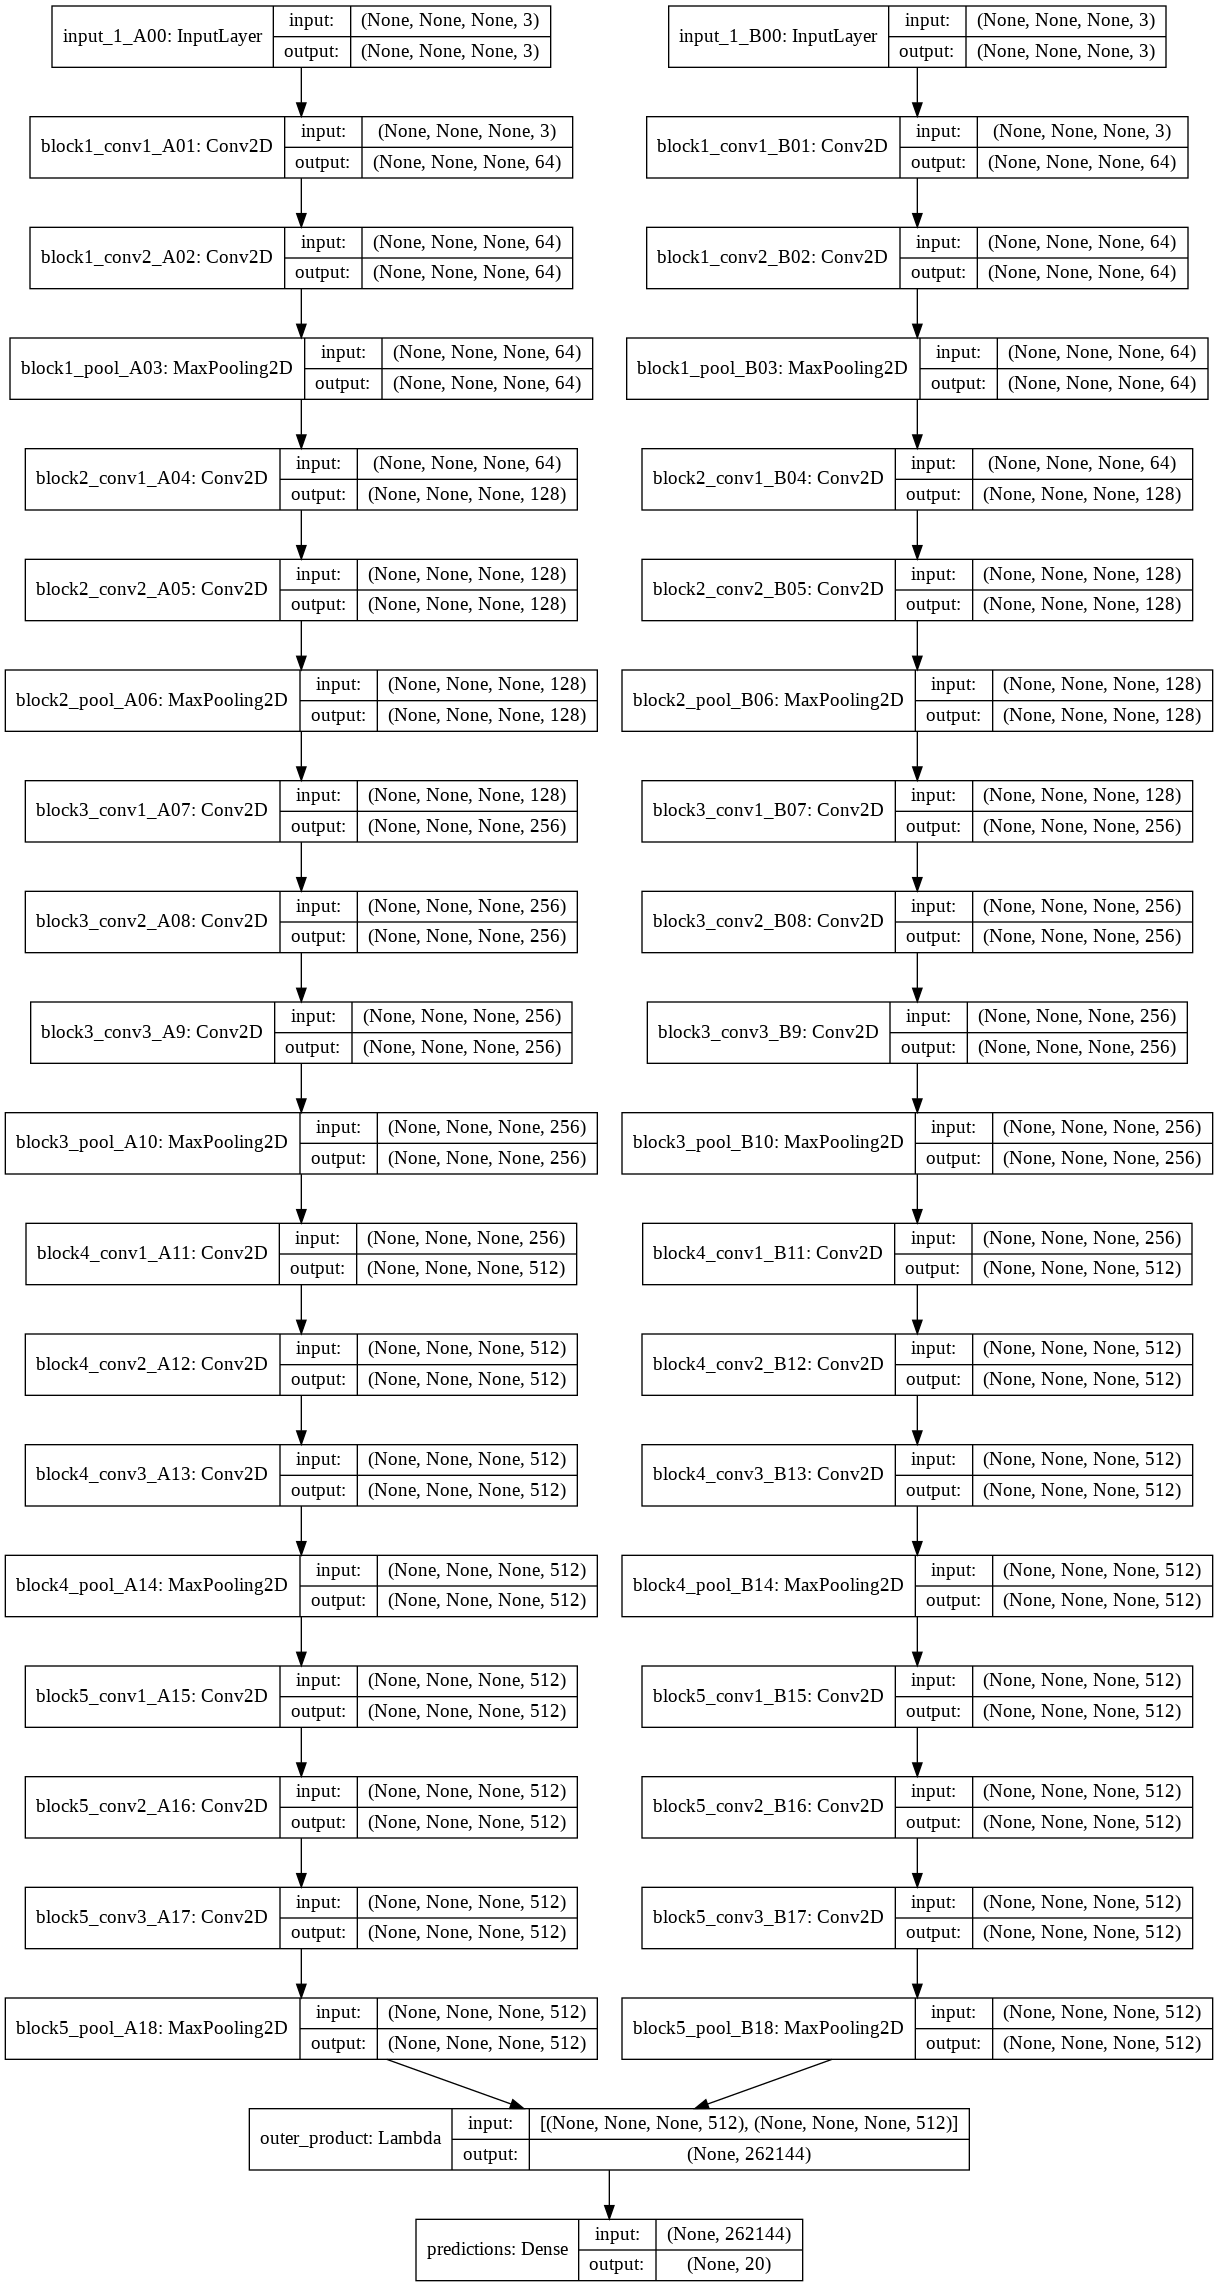

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

ValueError: ignored